# Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../fastai/') #fastai version 1.0
from fastai.vision import *
from fastai.vision.learner import model_meta
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score

PATH = Path('/home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection')
TRAIN_NAME = 'train'
TRAIN = PATH/TRAIN_NAME
CSV_NAME = 'train_labels.csv'
LABELS = PATH/CSV_NAME
TEST_NAME = 'test'
TEST = PATH/TEST_NAME
SAMPLE = PATH/'sample_submission.csv'
SUBMISSIONS = PATH/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

TRAIN_LR_NAME = 'train_lr'
TRAIN_LR = PATH/TRAIN_LR_NAME

TRAIN_MR_NAME = 'train_mr'
TRAIN_MR = PATH/TRAIN_MR_NAME

SUPERRES_MODELS_NAME = 'models_superres'
SUPERRES_MODELS = PATH/SUPERRES_MODELS_NAME

nw = 8   #number of workers for data loader
torch.backends.cudnn.benchmark=True
seed = 42
np.random.seed(seed)

#def batch_stats(self, funcs:Collection[Callable]=None)->Tensor:
#        "Grab a batch of data and call reduction function `func` per channel"
#        funcs = ifnone(funcs, [torch.mean,torch.std])
#        x = self.one_batch(ds_type=DatasetType.Train, denorm=False)[0].cpu()
#        return [func(channel_view(x), 1) for func in funcs]
#    
#    
#vision.data.ImageDataBunch.batch_stats = batch_stats

sz = 96
bs = 64
epochs_frozen = 1
epochs_unfrozen = 20

#fastai defaults
tta_beta = 0.4 
tta_scale = 1.35
dropout = 0.5
wd = 0.01

#non defaults


# Extra Models

In [2]:
#https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb

## utils

from fastai.torch_core import flatten_model

def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


## Models

### NASNetAMobile

def identity(x): return x

def nasnetamobile(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.nasnetamobile(pretrained=pretrained, num_classes=1000)  
    model.logits = identity
    model_meta[nasnetamobile] =  { 'cut': identity, 'split': lambda m: (list(m[0][0].children())[8], m[1]) }
    return nn.Sequential(model)

#arch_summary(lambda _: nasnetamobile(False)[0])

### se_resnext50

def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    _se_resnet_meta = {'cut': -2, 'split': lambda m: (m[0][3], m[1]) }
    model_meta[se_resnext50_32x4d] =  _se_resnet_meta
    return model

#arch_summary(lambda _: pretrainedmodels.se_resnext50_32x4d(pretrained=None))

# Crappify images

In [2]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn
        img = PIL.Image.open(self.path_hr/fn)
        dest.parent.mkdir(parents=True, exist_ok=True)
        targ_sz = resize_to(img, 48, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        #q = random.randint(10,70)
        img.save(dest, quality=60)

In [3]:
fnames = [os.path.split(p)[-1] for p in list(TRAIN.iterdir())]

In [4]:
parallel(crappifier(TRAIN_LR, TRAIN), fnames)

In [4]:
parallel(crappifier(TRAIN_MR, TRAIN), fnames)

# Data

In [7]:
src = (ImageImageList.from_folder(TRAIN_LR)
        .split_by_rand_pct(0.1, seed=seed))

In [8]:
tfms = ([RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)],
        [])

#tfms = ([], [])

In [9]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: TRAIN/x.name)
           .transform(tfms, size=size, tfm_y=True)
           .databunch(bs=bs)
           .normalize(do_y=True))

    data.c = 3
    return data

In [ ]:
data = get_data(bs,sz)

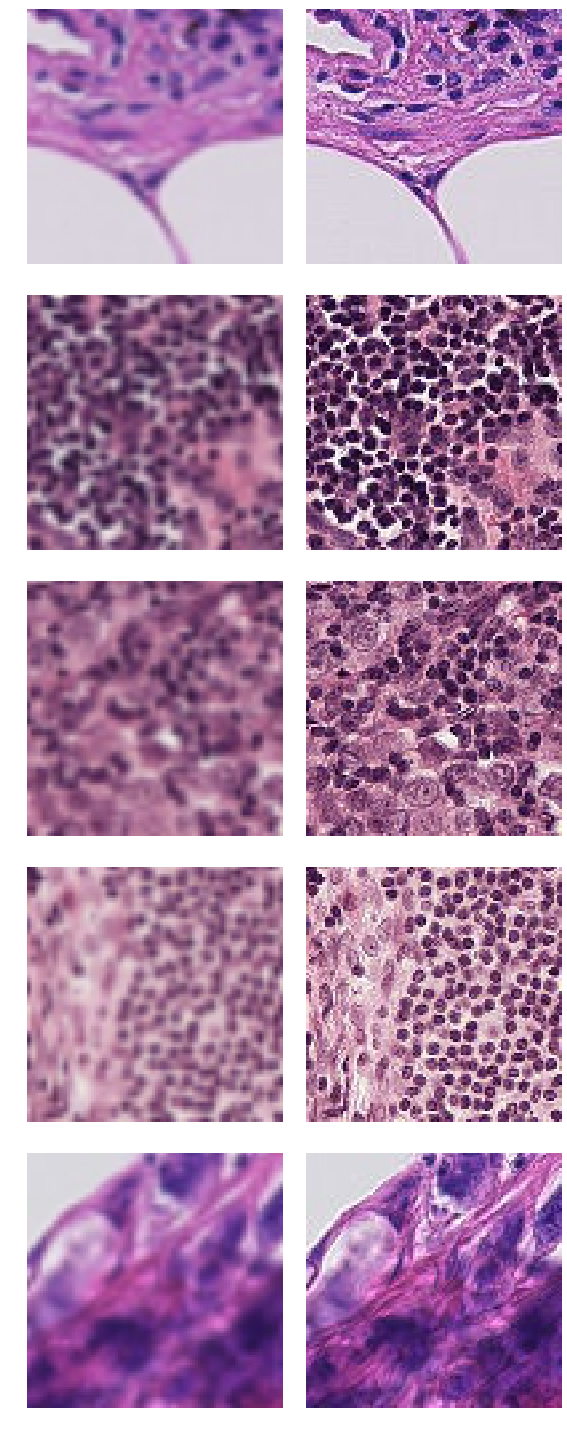

In [7]:
data.show_batch()

# Feature Loss 

In [ ]:
hook_outputs

t = data.valid_ds[0][1].data
t = torch.stack([t,t])

def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

gram_matrix(t)

base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))] #+ [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        #self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             #for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Train 

In [6]:
arch = se_resnext50_32x4d
arch = torchvision.models.resnet34

In [7]:
arch

<function torchvision.models.resnet.resnet34(pretrained=False, **kwargs)>

In [8]:
wd = 1e-3
#learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
#                     blur=True, norm_type=NormType.Weight)

learn = unet_learner(data, 
                     arch, 
                     wd=wd, 
                     loss_func=F.l1_loss,
                     blur=True, 
                     norm_type=NormType.Weight)

gc.collect();

In [9]:
learn.loss_func

<function torch.nn.functional.l1_loss(input, target, size_average=None, reduce=None, reduction='mean')>

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


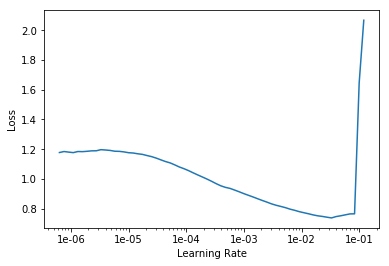

In [14]:
learn.lr_find()
learn.recorder.plot()

In [10]:
lr = 3e-3

In [11]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [12]:
path_frozen = SUPERRES_MODELS/'5-superres-frozen-without_gram-l1_loss'

epoch,train_loss,valid_loss,time
0,0.299966,0.300992,12:42
1,0.294616,0.296023,12:38
2,0.295182,0.293133,12:39
3,0.292890,0.291227,12:40
4,0.291481,0.289978,12:40
5,0.289379,0.288935,12:42
6,0.290332,0.288849,12:43
7,0.292297,0.288093,12:44
8,0.288523,0.287328,12:45
9,0.286631,0.285372,12:44


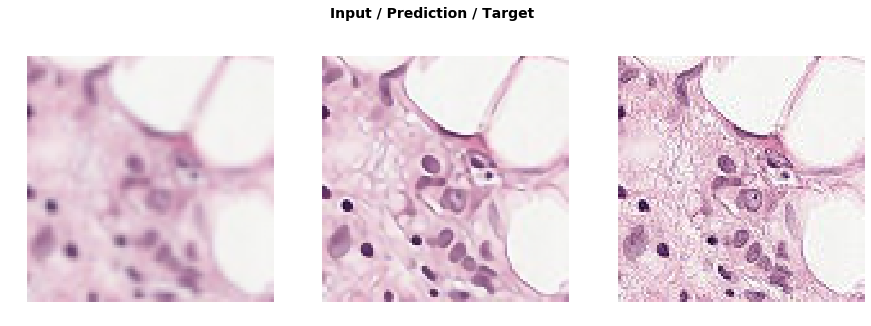

In [13]:
do_fit(path_frozen, slice(lr))

In [14]:
#learn.load(path_frozen)

In [15]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


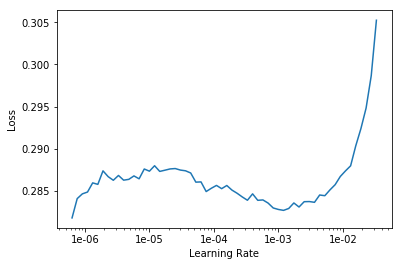

In [16]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr2 = 1e-4
lr3 = 1e-3

In [19]:
path_unfrozen = SUPERRES_MODELS/'5-superres-unfrozen-without_gram-l1_loss'

epoch,train_loss,valid_loss,time
0,0.284975,0.285331,13:17
1,0.286751,0.285331,13:19
2,0.290028,0.285486,13:19
3,0.284708,0.285243,13:21
4,0.286551,0.285620,13:19
5,0.287162,0.285574,13:19
6,0.287498,0.285395,13:17
7,0.285014,0.285325,13:17
8,0.287404,0.285157,13:20
9,0.284251,0.283633,13:20


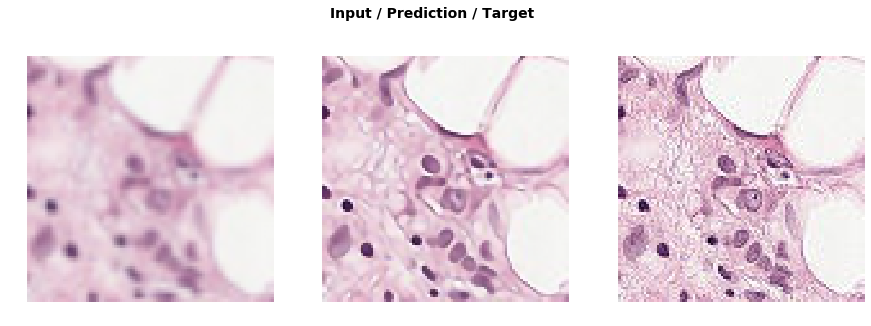

In [20]:
do_fit(path_unfrozen, slice(1e-5,lr))

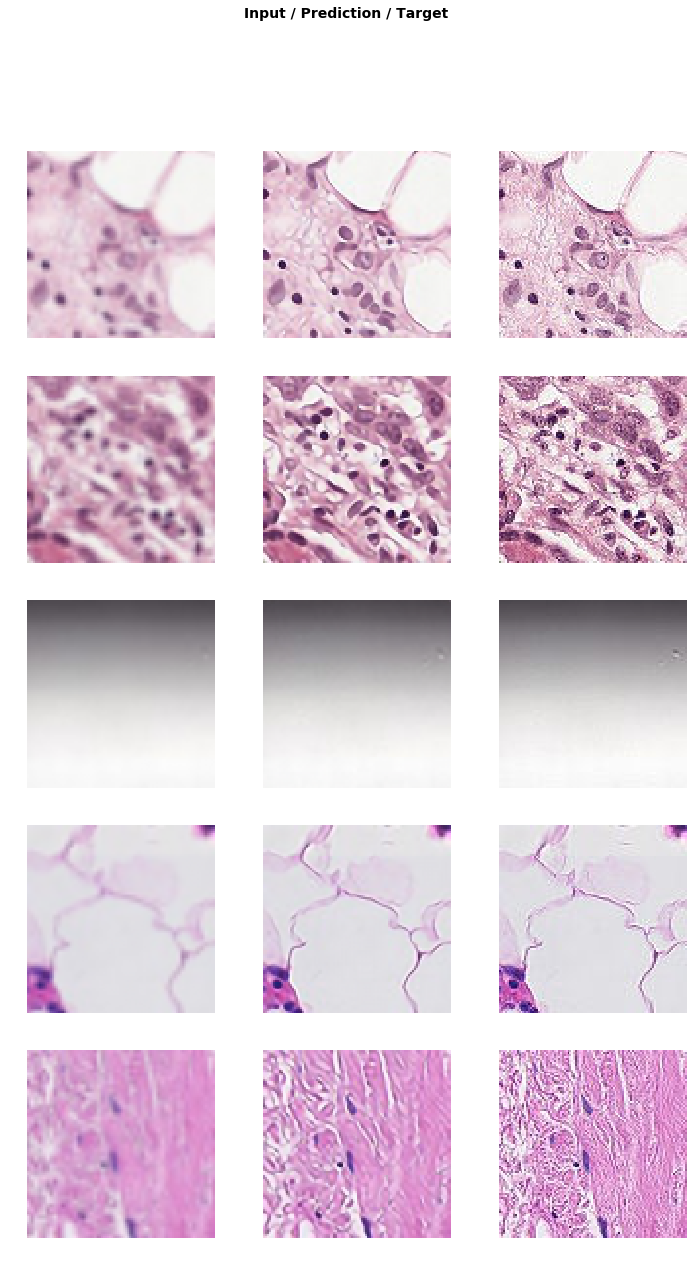

In [21]:
learn.show_results()

# Upsample original sized images 

In [16]:
arch_test = torchvision.models.resnet34

In [17]:
#model_path_test = SUPERRES_MODELS/'5-superres-unfrozen-without_gram-l1_loss'
model_path_test = SUPERRES_MODELS/'2-superres-unfrozen'

In [18]:
data_test = (ImageImageList.from_folder(TRAIN_LR)
        .split_by_rand_pct(0.1, seed=seed)
        .label_from_func(lambda x: TRAIN/x.name)
        .add_test_folder(test_folder=TRAIN)
        .transform(tfms, size=sz, tfm_y=False)
        .databunch(bs=bs)
        .normalize(do_y=False))

data_test.c = 3

In [19]:
learn_test = unet_learner(data_test, arch_test, wd=wd,
                     blur=True, norm_type=NormType.Weight)

In [20]:
learn_test.load(model_path_test)

Learner(data=ImageDataBunch;

Train: LabelList (198023 items)
x: ImageImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: ImageList
Image (3, 48, 48),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection/train_lr;

Valid: LabelList (22002 items)
x: ImageImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection/train_lr;

Test: LabelList (220025 items)
x: ImageImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection/train_lr, model=DynamicUnet(
  (layers): ModuleList(
    (0):

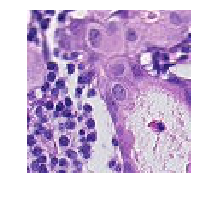

In [21]:
img = data_test.test_ds[10][0]; img.show()

In [22]:
pred = learn_test.predict(img)

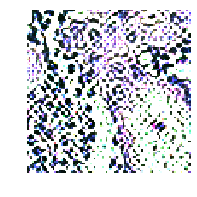

In [23]:
pred[0].show()

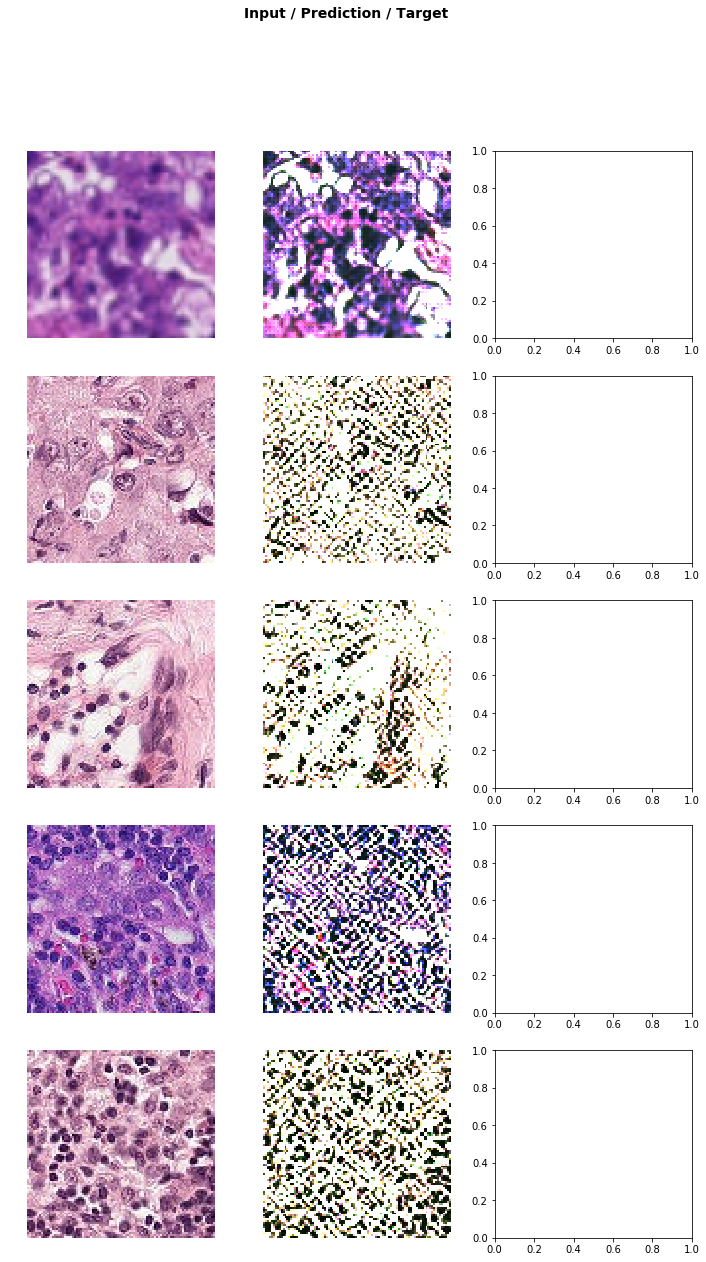

In [24]:
learn_test.show_results(ds_type=DatasetType.Test)